# imports

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import cv2
import os
import math
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,TensorBoard
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121, DenseNet169, DenseNet201
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.applications import NASNetLarge, NASNetMobile
from tensorflow.keras.applications import ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import time


# Functions

In [ ]:
def load_images_and_labels(folder_path):
    images = []
    labels = []

    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        label = filename[-5]
        if filename[-6] != "-":
          label = filename[-6]+filename[-5]

          images.append(img)
          labels.append(label)
    images = np.array(images)

    return images, labels
def split_data(images, labels, test_size=0.2, validation_size=0.1, random_state=42):
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=test_size, random_state=random_state,stratify=labels)

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=random_state,stratify=y_train)

    return X_train, X_val, X_test, y_train, y_val, y_test
def encode_labels(labels):
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    encoded_labels= to_categorical(encoded_labels)
    return encoded_labels
def resize_images_cv2(image_array,wdith,height):
    """
    Resize each image in the input numpy array to 224x224 pixels using cv2.

    Parameters:
    - image_array (numpy.ndarray): Input array of images.

    Returns:
    - resized_images (numpy.ndarray): Array of resized images.
    """
    resized_images = []

    for image in image_array:
        # Resize the image to 224x224 pixels using cv2
        resized_image = cv2.resize(image, (wdith,height))

        resized_images.append(resized_image)

    return np.array(resized_images)
def addCallbacks():
    cllbks=[]
    # Define the callback
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',  # You can use 'val_accuracy' or other metrics
        factor=0.1,           # Factor by which the learning rate will be reduced. new_lr = lr * factor
        patience=5,           # Number of epochs with no improvement after which learning rate will be reduced
        min_lr=1e-6,          # Lower bound on the learning rate
        verbose=1
    )
    cllbks.append(reduce_lr)
    # Define the EarlyStopping callback
    early_stopping = EarlyStopping(
            monitor='val_accuracy',  # Metric to monitor (e.g., validation loss)
            patience=patience,          # Number of epochs with no improvement before stopping
            verbose=1,            # Verbosity level (1 for updates, 0 for silent)
            restore_best_weights=True  # Restore model weights to the best observed during training
            )
    cllbks.append(early_stopping)

    log_dir = save_folder+"Logs/"+model_name
    tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
    cllbks.append(tensorboard_callback)
    return cllbks
def trainModel(mdl,X_train,y_train,X_val,y_val,cllbk,save_dir):
    steps_per_epoch = math.ceil(len(X_train) / batch_size)
    validation_steps = math.ceil(len(X_val) / batch_size)
    # X_train, X_val, X_test, y_train, y_val, y_test = split_data(Oimages, labels, test_size=0.2, validation_size=0.1, random_state=42)

    # Train the model
    history= mdl.fit(
        X_train,
        y_train,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=(X_val,y_val),
        validation_steps=validation_steps,
        callbacks=cllbk
    )

    # Save the fine-tuned model
    model.save(save_dir)
    return mdl,history
def testModel(mdl,X_test,y_test):
   
    # Assuming you have trained your model and you have X_test and y_test
    # If you have used one-hot encoding for your labels, you might need to convert predictions to class labels
    # Predictions from the model
    y_pred = mdl.predict(X_test)

    # Convert predictions to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
    recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
    f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", auc)
    print("Confusion Matrix:\n", conf_matrix)
    return conf_matrix,accuracy,precision,recall,f1
def plot_confusion_matrix(confusion_matrix, save_path=None):
    """
    Plot a confusion matrix as a heatmap.

    Parameters:
    - confusion_matrix (numpy.ndarray): Confusion matrix.
    - save_path (str): Path to save the heatmap plot. If None, the plot is displayed but not saved.

    Returns:
    - None
    """
    plt.figure(figsize=(8, 6))

    # Using Seaborn heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[0])],
                yticklabels=['Class {}'.format(i) for i in range(confusion_matrix.shape[1])])

    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
def createModel(imagesize,num_classes,pretrained_model):
  match pretrained_model:
    case "DenseNet121":
        base_model = tf.keras.applications.DenseNet121(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet169":
      base_model = tf.keras.applications.DenseNet169(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "DenseNet201":
      base_model = tf.keras.applications.DenseNet201(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionV3":
       base_model = tf.keras.applications.InceptionV3(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "InceptionResNetV2":
       base_model = tf.keras.applications.InceptionResNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNet":
       base_model = tf.keras.applications.MobileNet(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "MobileNetV2":
       base_model = tf.keras.applications.MobileNetV2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetLarge":
       base_model = tf.keras.applications.NASNetLarge(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "NASNetMobile":
       base_model = tf.keras.applications.NASNetMobile(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50":
      base_model = tf.keras.applications.ResNet50(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
  )
    case "ResNet101":
       base_model = tf.keras.applications.ResNet101(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152":
       base_model = tf.keras.applications.ResNet152(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet50V2":
       base_model = tf.keras.applications.ResNet50V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet101V2":
       base_model = tf.keras.applications.ResNet101V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "ResNet152V2":
       base_model = tf.keras.applications.ResNet152V2(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG16":
       base_model = tf.keras.applications.VGG16(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "VGG19":
       base_model = tf.keras.applications.VGG19(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case "Xception":
       base_model = tf.keras.applications.Xception(
      include_top=False,
      weights='imagenet',
      input_shape=imagesize,#(224, 224, 3),
      )
    case _ :
      exit()


  for layer in base_model.layers:
    layer.trainable = False

  model = models.Sequential([
      base_model,
      layers.GlobalMaxPool2D(),
      layers.Flatten(),
      layers.Dense(512, activation='relu'),
      layers.BatchNormalization(),
      layers.Dropout(0.2),
      layers.Dense(256, activation='relu'),
      layers.Dropout(0.2),
      layers.Dense(num_classes, activation='softmax')
  ])



  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model
def create_empty_csv_file(file_path):
    """
    Create an empty CSV file with row headers.

    The row headers are: Model Name, Accuracy, Precision, Recall, F1-Score, Testing Time, Training Time

    Parameters:
    - file_path: The file path where the CSV file will be saved.
    """

    # Create an empty DataFrame with the specified headers
    headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']
    df = pd.DataFrame(columns=headers)

    # Save to CSV file
    df.to_csv(file_path, index=False)

    print(f"Empty CSV file '{file_path}' created successfully.")
def append_to_csv(file_path, model_name, accuracy, precision, recall, f1_score, testing_time, training_time):
    """
    Append a row with evaluation metrics to an existing CSV file.

    Parameters:
    - file_path: The path to the CSV file.
    - model_name: Name of the model.
    - accuracy: Accuracy value.
    - precision: Precision value.
    - recall: Recall value.
    - f1_score: F1 score value.
    - testing_time: Time taken for testing in seconds.
    - training_time: Time taken for training in seconds.
    """

    # Check if the file exists
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        # If the file doesn't exist, create a new one with headers
        headers = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Testing Time', 'Training Time']
        df = pd.DataFrame(columns=headers)

    # Append a new row with the specified values
    new_row = pd.Series({'Model Name': model_name,
                        'Accuracy': accuracy,
                        'Precision': precision,
                        'Recall': recall,
                        'F1-Score': f1_score,
                        'Testing Time': testing_time,
                        'Training Time': training_time})

    # df=pd.concat(new_row, ignore_index=True)
    df = df.append(new_row, ignore_index=True)

    # Save to the same CSV file
    df.to_csv(file_path, index=False)

    print(f"Row appended to '{file_path}' successfully.")



# Paramters

In [ ]:
batch_size = 64
num_classes = 14
epochs=150
width=224
height=224
patience=25
img_size=(width, height, 3)
save_folder='/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/'
csv_file_path=save_folder+"results.csv"
create_empty_csv_file(save_folder+"results.csv")

# Load Data

In [ ]:
Oimages, Olabels = load_images_and_labels_f('../CSV-Images')

Loading Images: 100%|██████████| 2000/2000 [00:38<00:00, 52.57it/s]


##Preprocess Data

In [ ]:
labels = encode_labels(Olabels)  # Add your label encoding function
resized_images = resize_images_cv2(Oimages,width, height)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(resized_images, labels, test_size=0.2, validation_size=0.1, random_state=42)
del Oimages,Olabels,resized_images,labels

##DenseNet

###DenseNet121

In [ ]:
model_name="DenseNet121"
save_folder='./NewImagesModels/'
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_max_pooling2d (Glob  (None, 1024)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 839.2622528076172 seconds


13/13 [==============================] - 8s 216ms/step
Accuracy: 0.8625
Precision: 0.8680938133522601
Recall: 0.8625
F1 Score: 0.8622446259223434
AUC: 0.9953355263157896
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 4  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  0  0  0  0  1  0  0  0  0  1  1  0  0]
 [ 0  0  1  0 15  0  0  0  0  0  0  0  0  3  0  0  1  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 17  1  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  0  0  0 16  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  2  0  0  0  0  0  6  0]
 [ 0  0  0  1  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  2  0  0  0 15  0  0  0  0  0

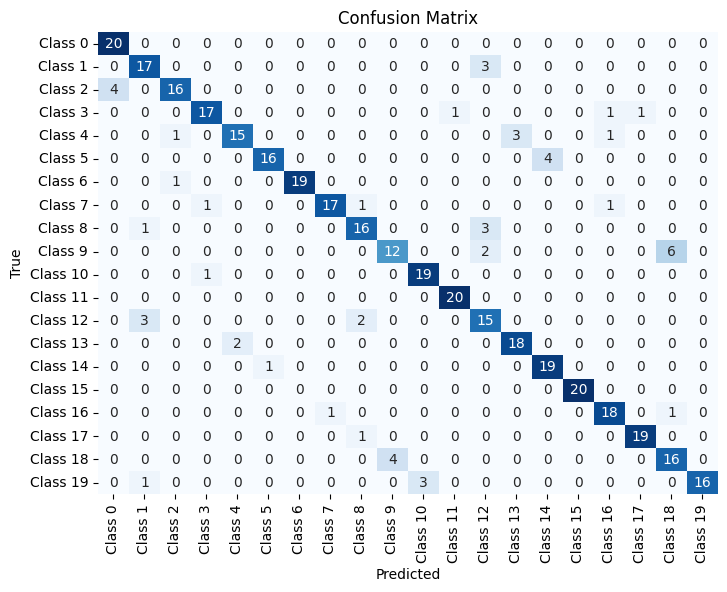

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')


In [ ]:
import pandas as pd
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###DenseNet169

In [ ]:
del model

In [ ]:
model_name="DenseNet169"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 1664)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 1664)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               852480    
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)              

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 932.5346171855927 seconds


13/13 [==============================] - 6s 177ms/step
Accuracy: 0.7725
Precision: 0.7825189471977398
Recall: 0.7725
F1 Score: 0.7691872184183778
AUC: 0.9893486842105264
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  0  0  0]
 [ 7  0 13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 11  3  0  3  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  2  0  0  0 11  1  0  0  1  0  0  0  0  5  0  0  0]
 [ 0  2  0  0  0  0  0  0 14  0  2  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 14  0  0  1  0  0  0  0  0  5  0]
 [ 0  1  1  1  0  0  0  0  0  0 10  0  1  0  0  0  0  0  0  6]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  1  0  2  0 12  0  0  0  0  0

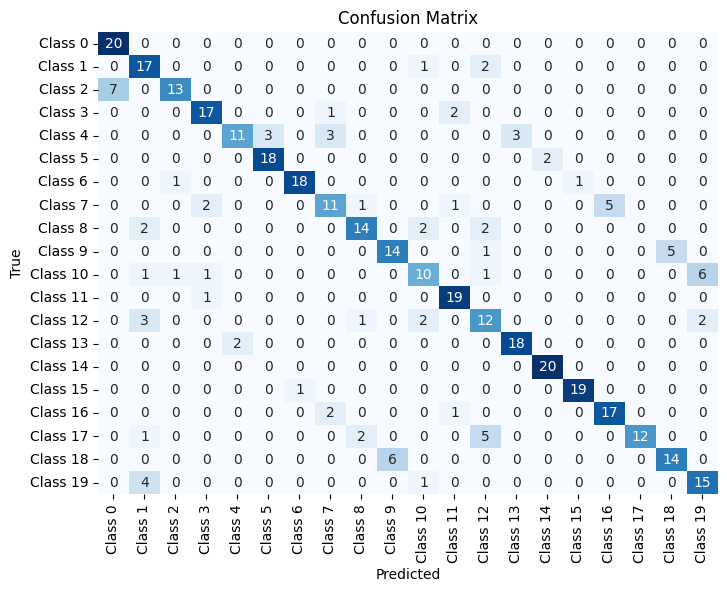

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###DenseNet201

In [ ]:
del model

In [ ]:
model_name="DenseNet201"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

74836368/74836368 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 1920)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 1920)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               983552    
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1416.1037459373474 seconds


13/13 [==============================] - 7s 207ms/step
Accuracy: 0.8575
Precision: 0.8660812722229635
Recall: 0.8575
F1 Score: 0.8559901272038104
AUC: 0.9955723684210526
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 3  0 17  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  2  0 12  0  0  0  0  0  0  0  0  4  1  0  0  0  1  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  2  0  0  0  0  0  5  0]
 [ 0  1  1  1  0  0  0  0  0  0 14  0  1  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  1  0  1  0 16  0  0  0  0  0

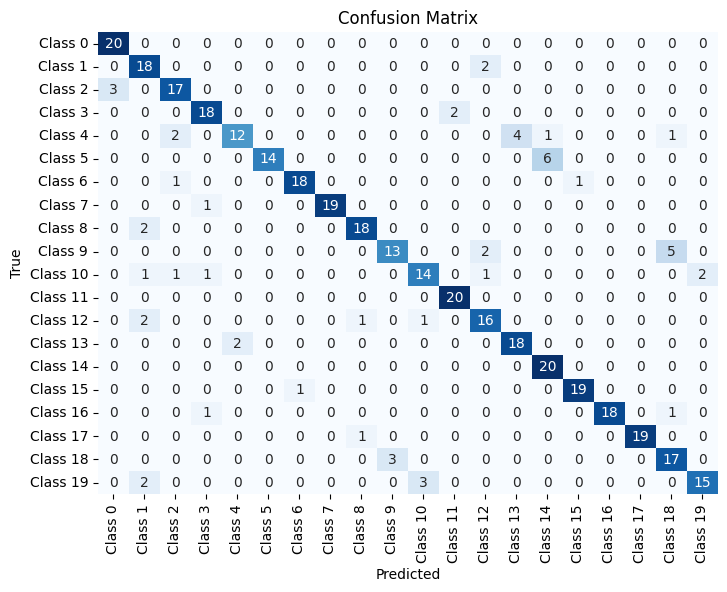

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##Xception

In [ ]:
del model

In [ ]:
model_name="Xception"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_3 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_7 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 806.7632863521576 seconds


13/13 [==============================] - 5s 197ms/step
Accuracy: 0.8
Precision: 0.8165228358193259
Recall: 0.8
F1 Score: 0.7976891235867793
AUC: 0.991611842105263
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 17  0  0  0  0  0  0  0  0  0  0  3  0  0  0  0  0  0  0]
 [ 4  0 14  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  5  0  0  0  0  0  0  1  0]
 [ 0  0  0  0 11  0  0  1  0  0  0  0  0  7  0  0  1  0  0  0]
 [ 0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  1  0  0  0 18  0  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  1  0  0  0  0  0  0 14  1  1  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  0  0  6  0]
 [ 0  1  0  0  0  0  0  1  0  0 10  0  1  0  0  0  0  1  1  5]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  2  1  0  0 13  0  0  0  0  0  0  0]

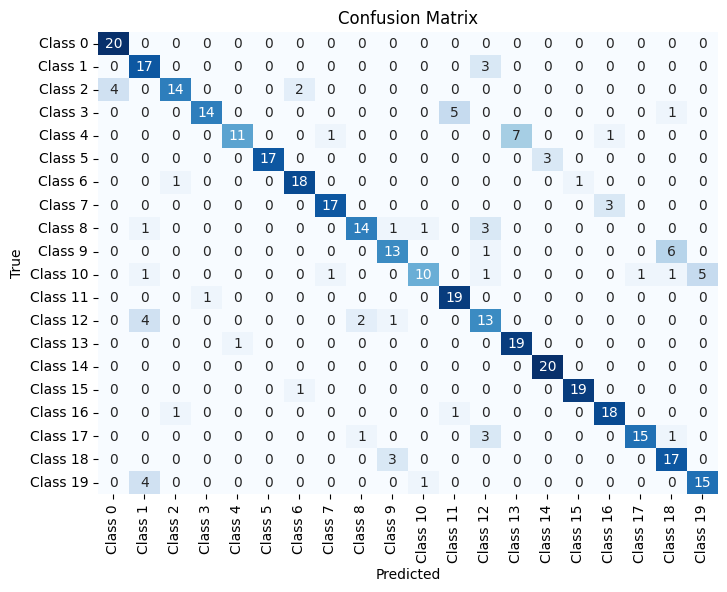

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##VGG

####VGG16

In [ ]:
del model

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_8 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 803.811473608017 seconds


13/13 [==============================] - 7s 265ms/step
Accuracy: 0.895
Precision: 0.8995986012461985
Recall: 0.895
F1 Score: 0.8946016555360675
AUC: 0.9954013157894739
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 16  1  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  1  0  0  0  0  0  0  1  0  0  0]
 [ 0  1  0  0  0  0  0  1 15  0  0  0  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0]
 [ 0  0  1  0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  2  0  0  0 16  0  0  0  0  0  

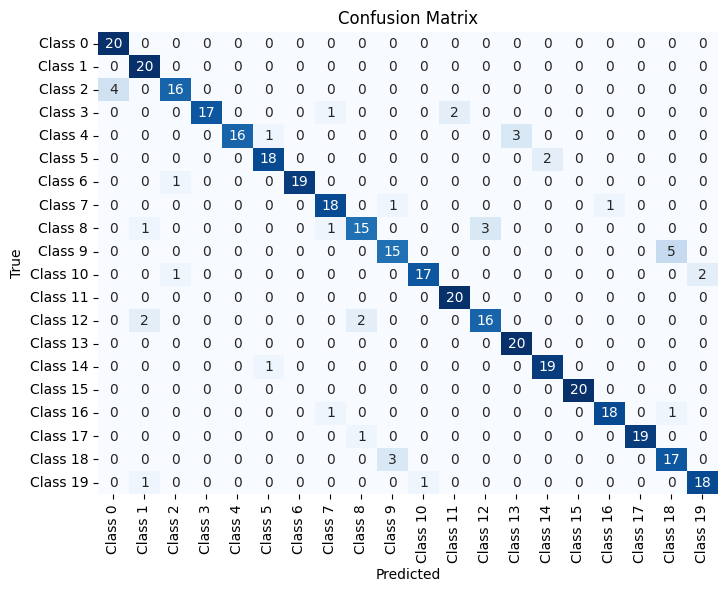

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


####VGG19

In [ ]:
del model

In [ ]:
model_name="VGG19"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

80134624/80134624 [==============================] - 0s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_max_pooling2d_5 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_9 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1016.3343036174774 seconds


13/13 [==============================] - 2s 140ms/step
Accuracy: 0.875
Precision: 0.8791731794999395
Recall: 0.875
F1 Score: 0.8737656062376934
AUC: 0.9958223684210527
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0 16  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 14  0  0  0  1  1  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 13  1  0  0  0  0  0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 19  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  1  0  0 16  0  0  0  0  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  1  0  0  0 18  0  0  0  0  0  

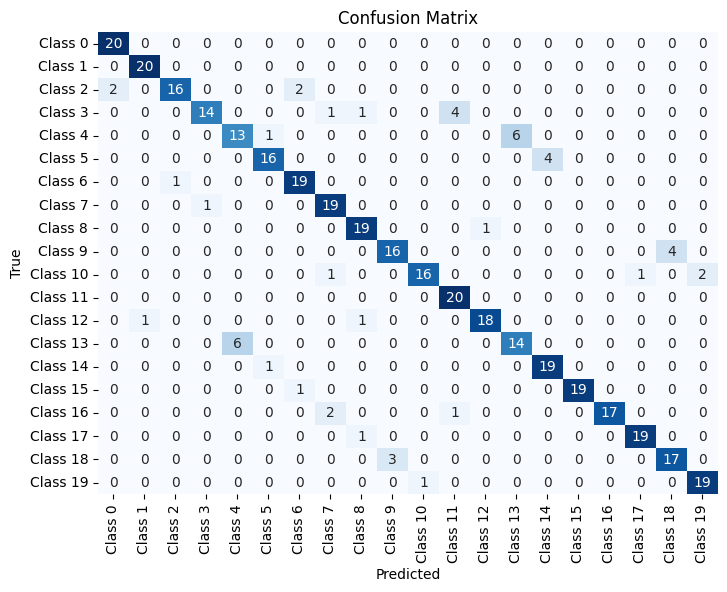

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-33-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##NasNet

###NASNetLarge

In [ ]:
del model

In [ ]:
model_name="NASNetLarge"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

343610240/343610240 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 4032)        84916818  
                                                                 
 global_max_pooling2d (Glob  (None, 4032)              0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 4032)              0         
                                                                 
 dense (Dense)               (None, 512)               2064896   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                       

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

###NASNetMobile

In [ ]:
del model

In [ ]:
model_name="NASNetMobile"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

##ResNet

###ResNet50

In [ ]:
del model

In [ ]:
model_name="ResNet50"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

###ResNet101

In [ ]:
del model

In [ ]:
model_name="ResNet101"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

171446536/171446536 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 541.8002219200134 seconds


13/13 [==============================] - 4s 155ms/step
Accuracy: 0.8575
Precision: 0.8603571397381131
Recall: 0.8575
F1 Score: 0.8548359306318976
AUC: 0.9954342105263159
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 2  0 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 16  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  2  0  0  0  0  0  0  0  5  1  0  0  0  0  0]
 [ 0  0  0  0  0 19  0  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  0  0  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  0  0  0  0 18  1  0  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 12  0  0  2  0  0  0  0  0  5  0]
 [ 0  0  0  2  0  0  0  0  0  0 16  0  1  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  2  0  0  0  0  0  0  3  0  1  0 14  0  0  0  0  0

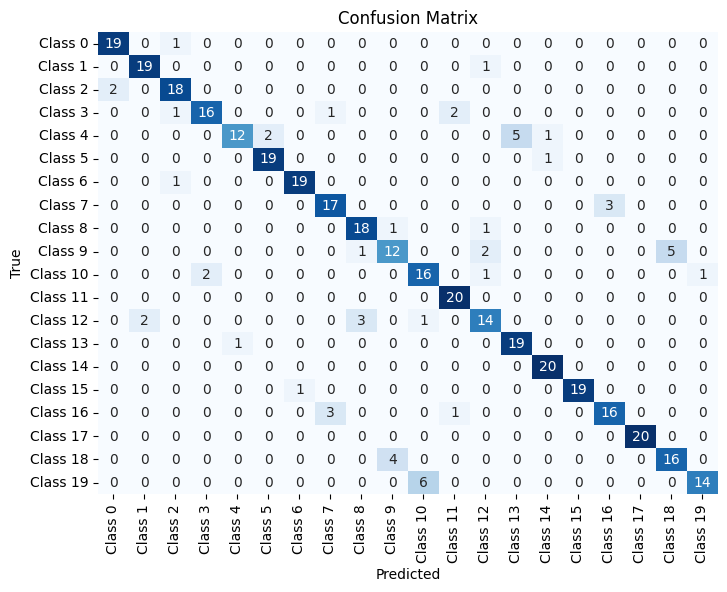

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet152

In [ ]:
del model

In [ ]:
model_name="ResNet152"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

234698864/234698864 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_2 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 692.711354970932 seconds


13/13 [==============================] - 6s 223ms/step
Accuracy: 0.8675
Precision: 0.8713599547578548
Recall: 0.8675
F1 Score: 0.8646548900715385
AUC: 0.9959605263157894
Confusion Matrix:
 [[20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0 14  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  1  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 15  2  0  0  0  0  0  0  0  3  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  2  0  0  0  0  0  0 15  0  1  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 12  0  0  2  0  0  0  0  0  6  0]
 [ 0  0  1  1  0  0  0  0  0  0 15  0  0  0  0  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  2  0  0  0 17  0  0  0  0  0

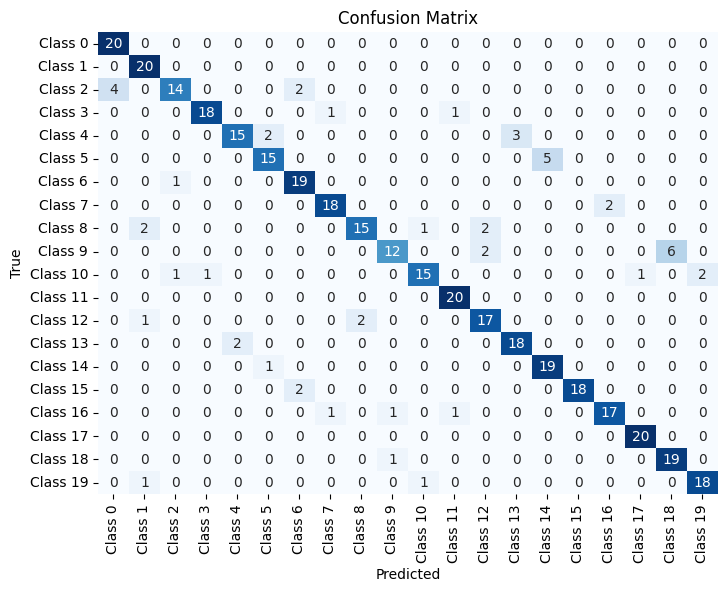

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet50V2

In [ ]:
del model

In [ ]:
model_name="ResNet50V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_max_pooling2d_3 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_3 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 446.87058305740356 seconds


13/13 [==============================] - 3s 125ms/step
Accuracy: 0.8375
Precision: 0.8418653046823057
Recall: 0.8375
F1 Score: 0.8363087276676824
AUC: 0.9934078947368421
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 18  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 5  0 13  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 17  0  0  0  1  0  0  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 14  1  0  0  0  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 16  1  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  2  0  0  0  0  0  0 16  0  1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 12  0  0  1  0  0  0  0  0  6  0]
 [ 0  1  1  1  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  0  0  1  0 15  0  0  0  0  0

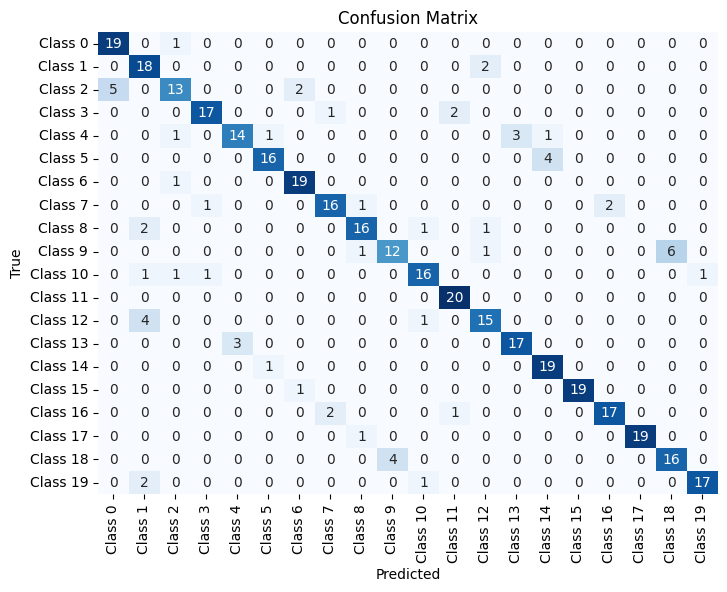

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet101V2

In [ ]:
del model

In [ ]:
model_name="ResNet101V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

171317808/171317808 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_max_pooling2d_4 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_4 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 872.4507994651794 seconds


13/13 [==============================] - 3s 153ms/step
Accuracy: 0.7825
Precision: 0.7969517577588066
Recall: 0.7825
F1 Score: 0.7777992727227899
AUC: 0.9913157894736842
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 20  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  0 14  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  1  0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  1  0 11  1  0  0  0  0  0  0  0  7  0  0  0  0  0  0]
 [ 0  0  0  0  0 14  0  0  0  0  0  0  0  0  6  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 13  1  0  0  0  0  0  0  0  5  0  0  0]
 [ 0  1  0  0  0  0  0  0 12  0  2  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 11  0  0  2  0  0  0  0  0  7  0]
 [ 0  0  0  2  0  0  0  0  0  0 11  0  0  0  0  0  0  0  0  7]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  0  0  0  1  0 11  0  0  0  0  1

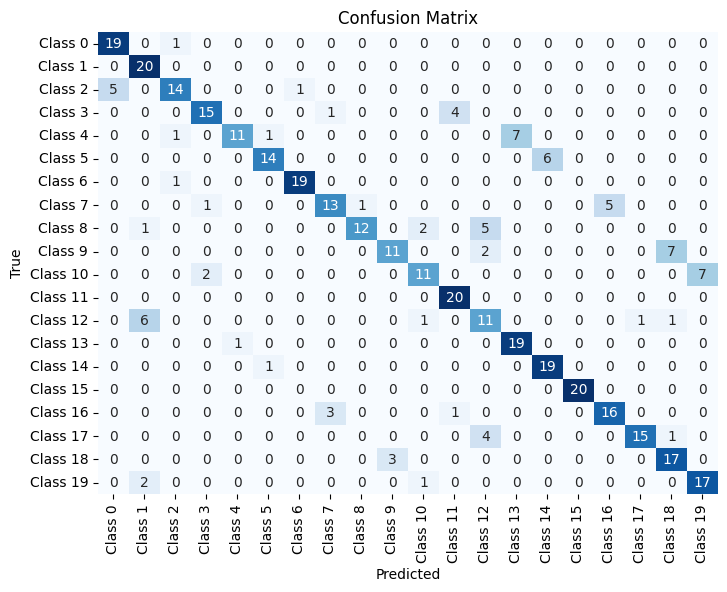

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###ResNet152V2

In [ ]:
del model

In [ ]:
model_name="ResNet152V2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

234545216/234545216 [==============================] - 2s 0us/step
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_max_pooling2d_5 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1278.9341135025024 seconds


13/13 [==============================] - 6s 221ms/step
Accuracy: 0.76
Precision: 0.7655521373334843
Recall: 0.76
F1 Score: 0.7539897700295372
AUC: 0.9879934210526315
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  0  0  0  0  0  0  1  0  2  0  0  0  0  1  0  0]
 [ 6  0 14  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 16  0  0  0  1  0  0  0  3  0  0  0  0  0  0  0  0]
 [ 0  0  2  1  7  1  0  1  0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0  0  5  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 12  1  0  0  0  0  0  0  0  6  0  0  0]
 [ 0  1  0  0  0  0  0  0 14  0  1  0  2  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  1  0  0  0  0  0  6  0]
 [ 0  1  0  2  0  0  0  0  0  0 12  0  0  0  0  0  0  2  0  3]
 [ 0  0  0  0  0  0  0  0  0  0  0 20  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  4  0  1  0 10  0  0  0  0  0  0 

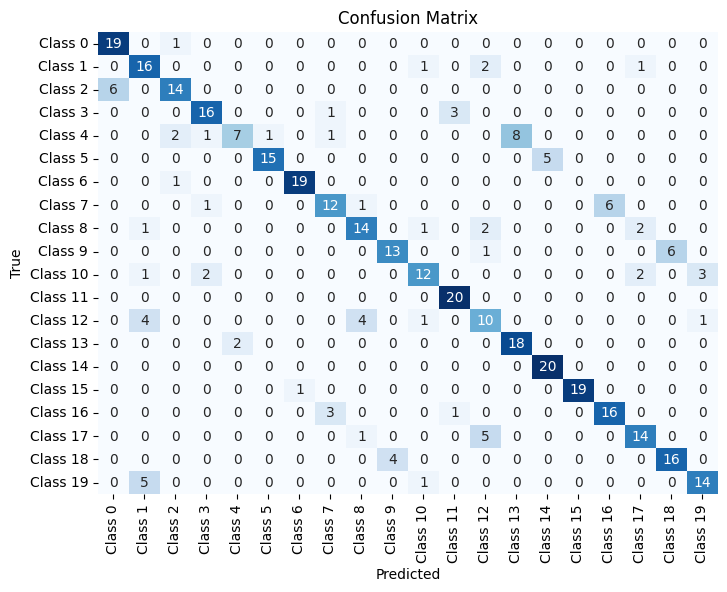

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


##Inception

###InceptionV3

In [ ]:
del model

In [ ]:
model_name="InceptionV3"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

87910968/87910968 [==============================] - 1s 0us/step
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_max_pooling2d_6 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_18 (Dense)            (None, 512)               1049088   
                                                                 
 batch_normalization_100 (B  (None, 512)               2048      
 atchNormalization)                                              
                                                       

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 424.3933484554291 seconds


13/13 [==============================] - 4s 146ms/step
Accuracy: 0.8175
Precision: 0.8272200676841444
Recall: 0.8175
F1 Score: 0.8143330927975222
AUC: 0.9930197368421052
Confusion Matrix:
 [[19  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 6  0 13  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 13  0  0  0  0  0  0  0  6  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 11  1  0  0  0  0  0  0  0  7  0  0  0  0  1  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  4  0  0  0  0  0]
 [ 0  0  1  0  0  0 19  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  1  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  1  0  0  0  0  0  0 13  0  0  0  5  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  3  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  0  1  0  0 15  0  0  0  0  0  0  0  0  4]
 [ 0  0  0  1  0  0  0  0  0  0  0 19  0  0  0  0  0  0  0  0]
 [ 0  4  0  0  0  0  0  0  3  0  0  0 13  0  0  0  0  0

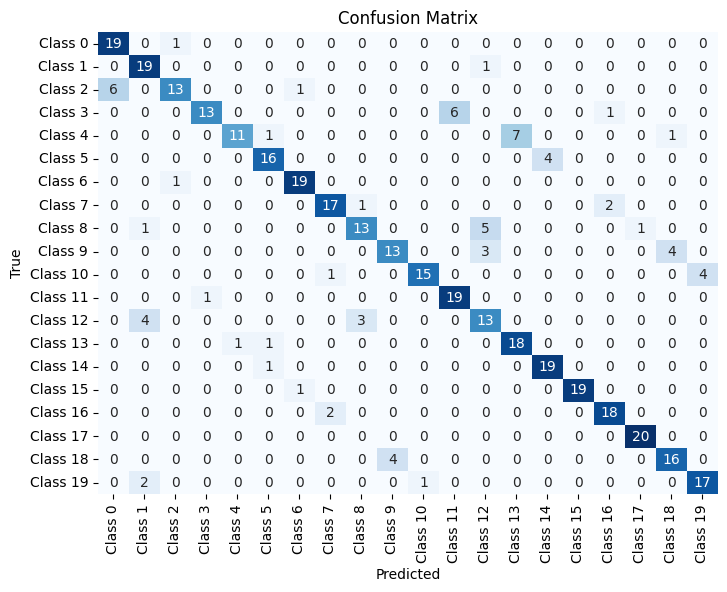

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

Row appended to '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/results.csv' successfully.


<ipython-input-14-841e4ebefb52>:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_row, ignore_index=True)


###InceptionResNetV2

In [ ]:
del model

In [ ]:
model_name="InceptionResNetV2"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

219055592/219055592 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Funct  (None, 5, 5, 1536)        54336736  
 ional)                                                          
                                                                 
 global_max_pooling2d_7 (Gl  (None, 1536)              0         
 obalMaxPooling2D)                                               
                                                                 
 flatten_7 (Flatten)         (None, 1536)              0         
                                                                 
 dense_21 (Dense)            (None, 512)               786944    
                                                                 
 batch_normalization_304 (B  (None, 512)               2048      
 atchNormalization)                                  

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training Time taken: 1012.9671738147736 seconds


In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)

#Augmented

In [ ]:
pip install Augmentor

##Generate Data

In [ ]:
import Augmentor

def perform_data_augmentation(input_path, output_path, augment_count=500):
    """
    Perform data augmentation on images in the input_path and save the augmented images to the output_path.

    Parameters:
    - input_path: The path to the directory containing the original images.
    - output_path: The path to the directory where augmented images will be saved.
    - augment_count: The number of augmented images to generate for each original image.

    Returns:
    - None
    """

    # Initialize an Augmentor pipeline
    pipeline = Augmentor.Pipeline(input_path, output_directory=output_path)

    # Define augmentation operations
    pipeline.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    pipeline.zoom_random(probability=0.5, percentage_area=0.8)
    pipeline.flip_left_right(probability=0.5)
    pipeline.flip_top_bottom(probability=0.5)
    pipeline.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

    # Execute the augmentation pipeline
    pipeline.sample(augment_count)

# Example usage:


Initialised with 2000 image(s) found.
Output directory set to /content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/trial2_2-transfer/aug.

Processing <PIL.Image.Image image mode=RGBA size=432x288 at 0x7F8AB0B83D00>: 100%|██████████| 20000/20000 [28:00<00:00, 11.90 Samples/s]


In [ ]:
input_path = "/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/Extracted_IMGs"
output_path = save_folder+"aug"


In [ ]:
# perform_data_augmentation(input_path, output_path,2000*10)


##Load Data

In [ ]:
import cv2
import os
from tqdm import tqdm
import numpy as np


def load_images_and_labels_augmented(folder_path):
    images = []
    labels = []
    i=0
    for filename in tqdm(os.listdir(folder_path), desc="Loading Images"):
        if i >=10000:
          break
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        # Assuming the label is the prefix before the first underscore
        label = filename.split('_')[3]
        if(filename.endswith("png")):

          # Check if label ends with "_inc" and modify accordingly
          if '_inc.png' in filename :
              # label = filename[:-4]  # Remove "_inc"
              label += "_inc"

          images.append(img)
          labels.append(label)
        i+=1
    images = np.array(images)

    return images, labels

In [ ]:
Aimages, Alabels = load_images_and_labels_augmented(output_path)
Aimages = resize_images_cv2(Aimages,width, height)


Loading Images:  50%|█████     | 10000/20000 [02:49<02:49, 59.06it/s]


In [ ]:
folder_path = '/content/drive/MyDrive/Masters/Masters-Phase4-Transfer_Learning/images_extracted/Extracted_IMGs'
Oimages, Olabels = load_images_and_labels(folder_path)
Oimages = resize_images_cv2(Oimages,width, height)


Loading Images: 100%|██████████| 2000/2000 [00:38<00:00, 52.45it/s] 


In [ ]:
all_images=np.concatenate((Oimages, Aimages), axis=0)
all_labels=np.concatenate((Olabels, Alabels), axis=0)


In [ ]:
all_labels = encode_labels(all_labels)  # Add your label encoding function

In [ ]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(all_images, all_labels, test_size=0.2, validation_size=0.1, random_state=42)

In [ ]:
del Aimages, Alabels,Oimages,Olabels,all_images,all_labels

In [ ]:
model_name="VGG16"
save_model_dir = save_folder+'fine_tuned_'+model_name+'_extracted_aug.h5'
model=createModel(img_size,num_classes,model_name)
callbacks=addCallbacks()
model.summary()
start_time = time.time()

model,history = trainModel(model,X_train,y_train,X_val,y_val,callbacks,save_model_dir)
end_time = time.time()
durationt = end_time - start_time
print(f"Training Time taken: {durationt} seconds")

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                         

NameError: ignored

In [ ]:
start_time = time.time()
cf,accuracy,precision,recall,f1=testModel(model,X_test,y_test)
end_time = time.time()
duration = end_time - start_time
print(f"Testing Time taken: {duration} seconds")
plot_confusion_matrix(cf, save_path=save_folder+'confusion_matrix_'+model_name+'_extracted.png')

In [ ]:
append_to_csv(csv_file_path, model_name, accuracy,precision,recall,f1, duration, durationt)